# SIE in NSIDC and on ACCESS-OM2-1 cycle 4 (extended)

In [1]:
import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0
from gsw import f as fcori
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 
import pandas as pd
import warnings
warnings.filterwarnings('ignore') #ignoring 10% trash warning

## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
import cf_xarray as cfxr
from xhistogram.xarray import histogram
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 

In [2]:
from dask.distributed import Client
client = Client(n_workers=28,memory_limit='190gb') 

In [3]:
session = cc.database.create_session()

exp = '01deg_jra55v140_iaf_cycle4'
exp_extension = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'

lat_slice=slice(-90,-50)
start_time='1979-01'
end_time='2024-12'
time_slice=slice(start_time,end_time)

In [4]:
yt_ocean  = cc.querying.getvar(exp, 'yt_ocean', session, n=1)
xt_ocean  = cc.querying.getvar(exp, 'xt_ocean', session, n=1)
tarea  = cc.querying.getvar(exp, 'area_t', session, n=1).sel(yt_ocean=lat_slice)

In [5]:
ICEf  = cc.querying.getvar(exp, 'aice_m', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})
ICEf_extension  = cc.querying.getvar(exp_extension, 'aice_m', session, frequency='1 monthly',start_time=start_time,\
                          end_time=end_time,chunks={'time': '200MB'})

Joining the IAF extension to the main IAF

In [6]:
ICEf_full = xr.concat((ICEf,ICEf_extension),dim = 'time')

Correcting the coordinates

In [7]:
ICEf_full = ICEf_full.rename({'ni':'xt_ocean','nj':'yt_ocean'})
ICEf_full['xt_ocean'] = xt_ocean.values
ICEf_full['yt_ocean'] = yt_ocean.values



cutting to get only the Southern Ocean

In [8]:
ICEf_full_SO = ICEf_full.sel(yt_ocean = lat_slice)

creating ice fraction Mask

In [52]:
SIE_xytmask = (ICEf_full_SO.where(ICEf_full_SO>0.155)*0)+1

In [71]:
SIA_xytmask = SIE_xytmask *ICEf_full_SO #Sea ice area

Calculating sea ice extent using model area and sea ice mask

In [72]:
SIA_SO_timeseries = (SIA_xytmask * tarea).sum(('xt_ocean','yt_ocean')).compute()

In [53]:
SIE_SO_timeseries = (SIE_xytmask * tarea).sum(('xt_ocean','yt_ocean')).compute()

In [54]:
#deseasoning data....
SIE_SO_timeseries_clim = SIE_SO_timeseries.groupby('time.month').mean()
SIE_SO_timeseries_clim

<xarray.DataArray (month: 12)> Size: 48B
array([1.2544217e+13, 5.0203087e+12, 2.1165105e+12, 3.8942616e+12,
       8.1050909e+12, 1.1994500e+13, 1.5005250e+13, 1.7108210e+13,
       1.8391828e+13, 1.8594451e+13, 1.7755315e+13, 1.6104967e+13],
      dtype=float32)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [55]:
#yearly timeseries
SIE_SO_timeseries_yearly = SIE_SO_timeseries.groupby('time.year').mean()

In [73]:
SIA_SO_timeseries_yearly = SIA_SO_timeseries.groupby('time.year').mean()

Importing observed Sea ice concentration

In [56]:

NSIDC = xr.open_dataset('/g/data/ik11/observations/seaice/NSIDC_v4/seaice_conc_monthly_sh_197811_202312_v04r00.nc')


In [57]:
dx = 25000 #m
dy = 25000 #m
NSIDC_area = dx * dy #m2

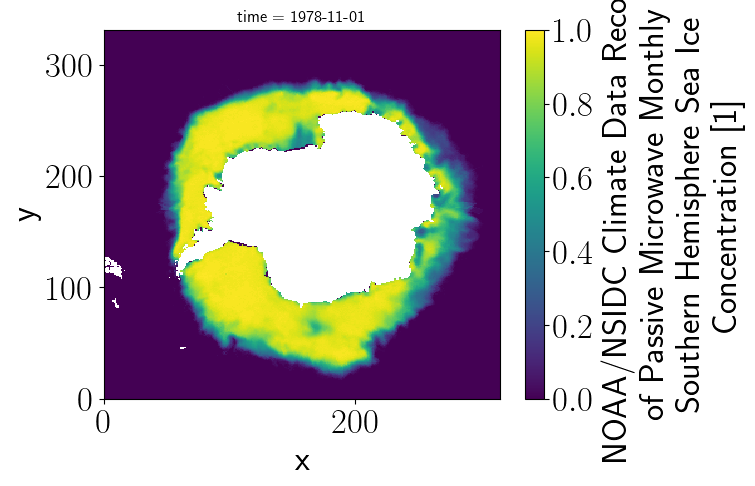

In [58]:
NSIDC_SIC = NSIDC.cdr_seaice_conc_monthly
NSIDC_SIC = NSIDC_SIC.where(NSIDC_SIC<2)
NSIDC_SIC.isel(tdim=0).plot()

In [66]:
#NSIDC mask for SIE
NSIDC_SIC_mask = (NSIDC_SIC.where(NSIDC_SIC>=0.15) * 0 )+1
#calculating SIE
NSIDC_SIE = (NSIDC_SIC_mask * NSIDC_area).sum(('x','y'))

In [67]:
#calculating annual mean
NSIDC_SIE_timeseries = NSIDC_SIE.isel(tdim = slice(0, 540))
NSIDC_SIE_timeseries = NSIDC_SIE_timeseries.rename({'tdim':'time'})
NSIDC_SIE_timeseries['time'] = SIE_SO_timeseries.time[:-1]
#yearly timeseries
NSIDC_SIE_timeseries_yearly = NSIDC_SIE_timeseries.groupby('time.year').mean()

#deseasoning data....
NSIDC_SIE_timeseries_clim = NSIDC_SIE_timeseries.groupby('time.month').mean()


#there is a little displacement on the centre taht is used for the monthly mean between NSIDC and OM2. so lets correct that.
NSIDC_SIE_timeseries_clim0 = NSIDC_SIE_timeseries_clim[1:]
NSIDC_SIE_timeseries_clim0['month'] = [1,2,3,4,5,6,7,8,9,10,11]
NSIDC_SIE_timeseries_climrest = NSIDC_SIE_timeseries_clim[0]
NSIDC_SIE_timeseries_climrest['month'] = 12
NSIDC_SIE_timeseries_clim = xr.concat((NSIDC_SIE_timeseries_clim0,NSIDC_SIE_timeseries_climrest),dim = 'month')



(9.5, 14.0)

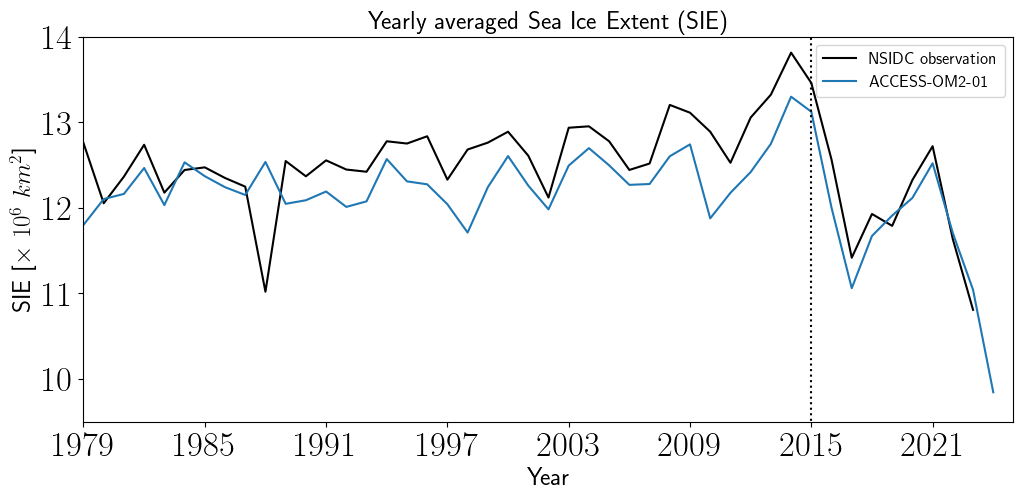

In [68]:
plt.figure(figsize=(12,5))
(NSIDC_SIE_timeseries_yearly * 1e-6 *1e-6).plot(color = 'black',label = 'NSIDC observation') # * 1e-6 km2
(SIE_SO_timeseries_yearly * 1e-6*1e-6).plot(label = 'ACCESS-OM2-01')# * 1e-6 km2
plt.legend(fontsize = 12)
plt.ylabel(r'SIE [$\times \ 10^6 \ km^2$]', fontsize = 18)
plt.xlabel('Year', fontsize = 18)
plt.title('Yearly averaged Sea Ice Extent (SIE)', fontsize = 18)
plt.xticks(ticks = np.arange(1979,2023,6))
plt.plot([2015,2015],[9,14],linestyle = ':', color = 'black')
plt.xlim(1979,2025)
plt.ylim(9.5,14)

Testing plot with SI index calculated by NSIDC.

In [62]:
# the dat it is in freaking spreadsheet. so lets just copy the annualdata
NSIDC_SI_Index = [11.7,11.23,11.435,11.64,11.389,11.454,11.618,11.088,11.554,12.131,\
11.426,11.41,11.545,11.399,11.42,11.774,11.795,11.769,11.39,11.738,11.761,11.747,11.673,\
11.222,11.969,11.961,11.695,11.461,11.687,12.239,12.049,12.107,11.501,12.004,12.524,12.776,\
12.414,11.202,10.749,11,10.876,11.602,11.579,10.726,9.853,10.376]

NSIDC_SI_Index_yearly = SIE_SO_timeseries_yearly.copy()
NSIDC_SI_Index_yearly.values = NSIDC_SI_Index

(9.5, 14.0)

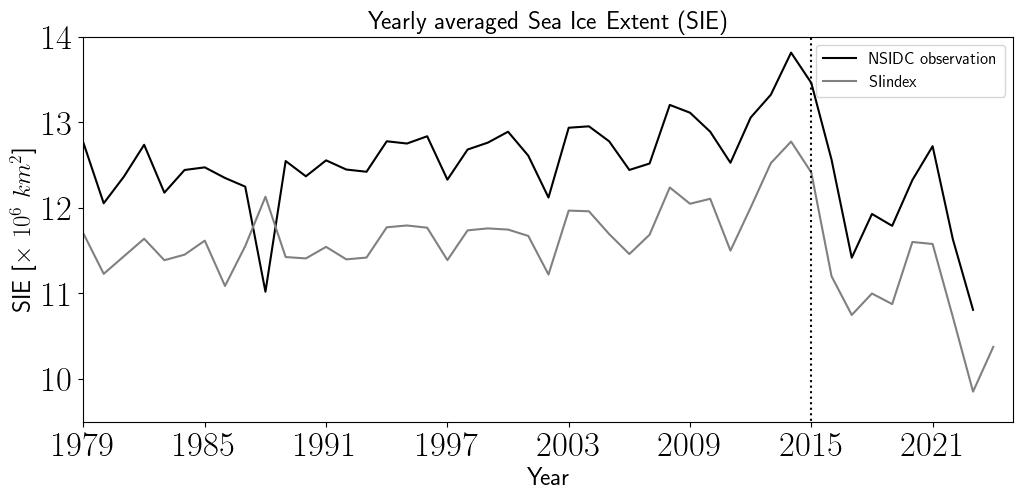

In [69]:
plt.figure(figsize=(12,5))
(NSIDC_SIE_timeseries_yearly * 1e-6 *1e-6).plot(color = 'black',label = 'NSIDC observation') # * 1e-6 km2
(NSIDC_SI_Index_yearly).plot(color = 'grey',label = 'SIindex') # * 1e-6 km2
plt.legend(fontsize = 12)
plt.ylabel(r'SIE [$\times \ 10^6 \ km^2$]', fontsize = 18)
plt.xlabel('Year', fontsize = 18)
plt.title('Yearly averaged Sea Ice Extent (SIE)', fontsize = 18)
plt.xticks(ticks = np.arange(1979,2023,6))
plt.plot([2015,2015],[9,14],linestyle = ':', color = 'black')
plt.xlim(1979,2025)
plt.ylim(9.5,14)

(9.0, 15.0)

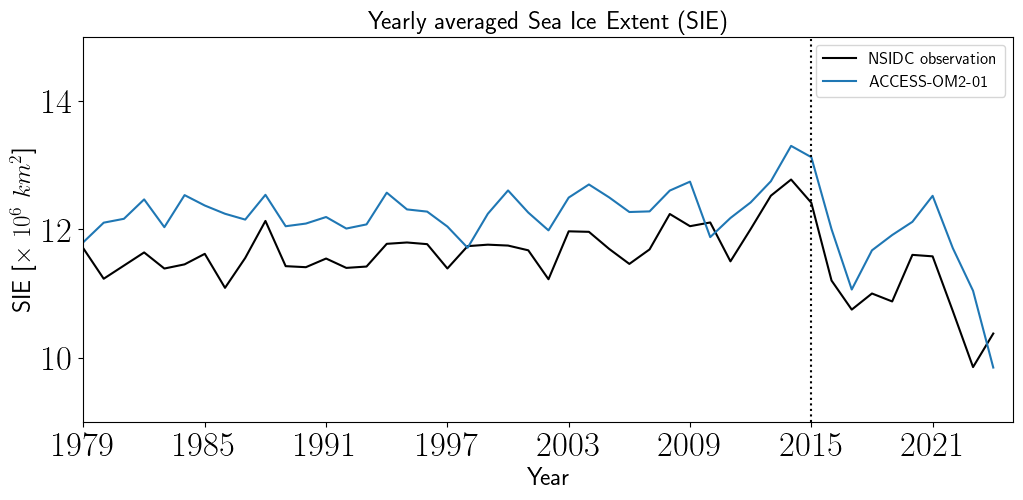

In [80]:
plt.figure(figsize=(12,5))
(NSIDC_SI_Index_yearly).plot(color = 'black',label = 'NSIDC observation') # * 1e-6 km2
(SIE_SO_timeseries_yearly * 1e-6*1e-6).plot(label = 'ACCESS-OM2-01')# * 1e-6 km2
plt.legend(fontsize = 12)
plt.ylabel(r'SIE [$\times \ 10^6 \ km^2$]', fontsize = 18)
plt.xlabel('Year', fontsize = 18)
plt.title('Yearly averaged Sea Ice Extent (SIE)', fontsize = 18)
plt.xticks(ticks = np.arange(1979,2029,6))
plt.plot([2015,2015],[9,20],linestyle = ':', color = 'black')
plt.xlim(1979,2025)
plt.ylim(9,15)

In [74]:
# the dat it is in freaking spreadsheet. so lets just copy the annualdata
NSIDC_SIA_Index = [8.855,8.41,8.645,8.798,8.572,8.707,8.867,8.304,8.796,9.243,8.716,\
8.697,8.71,8.544,8.652,9.069,8.906,8.838,8.695,8.852,8.869,9.014,8.757,8.542,9.103,\
9.067,8.789,8.705,8.986,9.299,9.195,9.164,8.729,9.225,9.699,9.868,9.426,8.37,8.12,\
8.303,8.365,8.828,8.683,8.022,7.376,7.842]

NSIDC_SIA_Index_yearly = SIE_SO_timeseries_yearly.copy()
NSIDC_SIA_Index_yearly.values = NSIDC_SIA_Index

(7.0, 11.0)

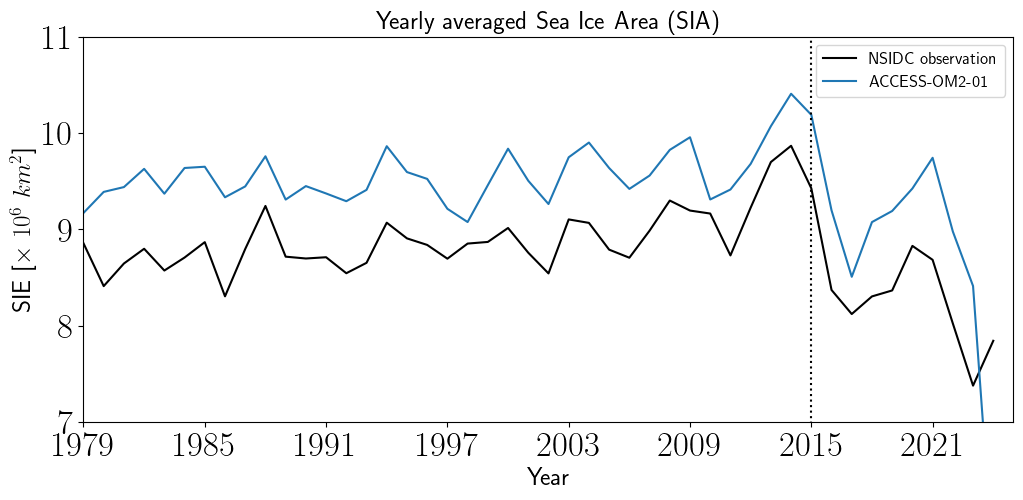

In [77]:
plt.figure(figsize=(12,5))
(NSIDC_SIA_Index_yearly).plot(color = 'black',label = 'NSIDC observation') # * 1e-6 km2
(SIA_SO_timeseries_yearly * 1e-6*1e-6).plot(label = 'ACCESS-OM2-01')# * 1e-6 km2
plt.legend(fontsize = 12)
plt.ylabel(r'SIE [$\times \ 10^6 \ km^2$]', fontsize = 18)
plt.xlabel('Year', fontsize = 18)
plt.title('Yearly averaged Sea Ice Area (SIA)', fontsize = 18)
plt.xticks(ticks = np.arange(1979,2023,6))
plt.plot([2015,2015],[4,14],linestyle = ':', color = 'black')
plt.xlim(1979,2025)
plt.ylim(7,11)

([<matplotlib.axis.XTick at 0x145dc1a98970>,
 [Text(1, 0, 'Jan'),
  Text(2, 0, 'Feb'),
  Text(3, 0, 'Mar'),
  Text(4, 0, 'Apr'),
  Text(5, 0, 'May'),
  Text(6, 0, 'Jun'),
  Text(7, 0, 'Jul'),
  Text(8, 0, 'Aug'),
  Text(9, 0, 'Sep'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Nov'),
  Text(12, 0, 'Dec')])

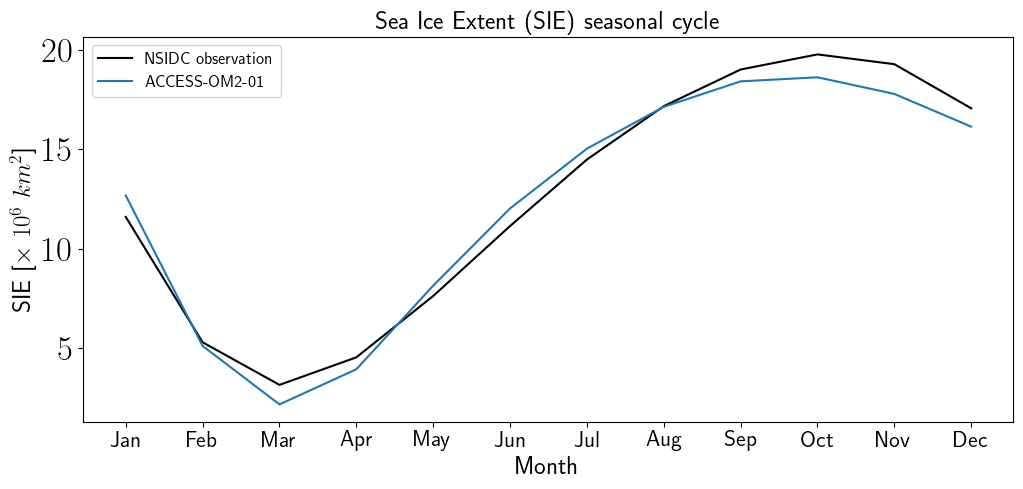

In [168]:
plt.figure(figsize=(12,5))
(NSIDC_SIE_timeseries_clim * 1e-6 *1e-6).plot(color = 'black',label = 'NSIDC observation') # * 1e-6 km2
(SIE_SO_timeseries_clim * 1e-6*1e-6).plot(label = 'ACCESS-OM2-01')# * 1e-6 km2
plt.legend(fontsize = 12)
plt.ylabel(r'SIE [$\times \ 10^6 \ km^2$]', fontsize = 18)
plt.xlabel('Month', fontsize = 18)
plt.title('Sea Ice Extent (SIE) seasonal cycle', fontsize = 18)
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks = np.arange(1,13),labels = month_names, fontsize = 16)
